[{'000000': 1.252e-12, '000001': 3.16236e-10, '000010': 2.9187e-11, '000011': 7.373828e-09, '000100': 1.267447e-09, '000101': 3.20203349e-07, '000110': 2.9553657e-08, '000111': 7.46633424e-06, '001000': 6.1798e-11, '001001': 1.561252e-08, '001010': 1.440981e-09, '001011': 3.6404457e-07, '001100': 6.2573615e-08, '001101': 1.5808382483e-05, '001110': 1.459058821e-06, '001111': 0.000368611595295, '010000': 6.1798e-11, '010001': 1.561252e-08, '010010': 1.440981e-09, '010011': 3.6404457e-07, '010100': 6.2573615e-08, '010101': 1.5808382483e-05, '010110': 1.459058821e-06, '010111': 0.000368611595295, '011000': 3.050973e-09, '011001': 7.70787327e-07, '011010': 7.1140994e-08, '011011': 1.7972815781e-05, '011100': 3.08924824e-06, '011101': 0.000780457035396, '011110': 7.2033474853e-05, '011111': 0.0181982889886, '100000': 6.1798e-11, '100001': 1.561252e-08, '100010': 1.440981e-09, '100011': 3.6404457e-07, '100100': 6.2573615e-08, '100101': 1.5808382483e-05, '100110': 1.459058821e-06, '100111': 0

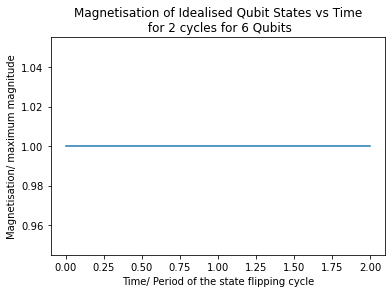

In [62]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
import scipy
from scipy import pi as pi
import matplotlib.pyplot as plt
import numpy as np 
from qiskit.chemistry import fermionic_operator as F

def QTC(L, q):
    """
    I've defined the number of cycles the code is run over as L, and q is the number of qubits being simulated.
    
    This function takes all the qubits initially in [1, 0] or |0> state, and flips the spins, performs a rotation
    operation on each qubit relative to another one and "measures" the resulting state. I say "measure" since it's
    run on a simulator and no actual measurement is being carried out on a quantum device.
    
    Once it's been run over all cycles, the resulting data is stored in a list which is appended after each cycle recording 
    the state measured and the probability of measuring that state. We then include a barrier between each cycle, so it's
    clear each cycle is performed independently.
    
    From this data, the graph plotting magnetisation vs time expressed as the number of cycles the system has gone though, 
    is plotted and it should show the system has a period double that of the driving field.
    """
    qtc = QuantumCircuit(q)
    backend = Aer.get_backend('statevector_simulator')
    for i in range(q):
        qtc.initialize([1,0], i)
    statedata = []
    histogram = []
    mag = []; T = []
    for i in range(L):    
        for j in range(q):
            qtc.x(j)
        # These are the rotational control gates coupling qubits. The code I attempted to implement this automatically
        # didn't run too well, this was the second attempt running the code. 
        for k in range(q):
            # theta = pi/4 * np.random.randint(1, 15)/20 # Attempted to introduce this random number for the angle but
            # it had no discernable affect on the histogram plot but may have an affect on the statedata.
            if k + 1 < q:
                qtc.crz(pi/2, k, k+1)
            else: break
        
        # This is the code added to randomise the rotation angle around x. 
        for k in range(q):
            theta = pi/5 * np.random.randint(1, 15)/20 # Attempted to introduce this random number for the angle
            # to simulate randomness of quantum behaviour to the environment
            qtc.rx(theta, k)
        
        # This is the code to run with q = 3, 3 qubits coupled to the consecutive one.
        #qtc.cp(pi/2, 0, 1)
        #qtc.cp(pi/2, 1, 2)
        
        
        # This code calculated the exact state, which was helpful to ensure the code was running 
        # as I hoped and will now be employed to make a more accurate plot.
        state = execute(qtc, backend).result().get_statevector()
        #print("Quibits state is = ", state)
        
        statedata.append(state)
        results = execute(qtc, backend).result().get_counts()
        histogram.append(results)
        #counts = state.get_counts()
        #print(state)
        
        # Trying to determine the magnetization from the states... This is needed to get the expectation value of
        # the magnetisation from the total magnetisation operator acting on the state times the complex conjugate of the
        # state itself, which can be determined by numpy.
        #magval = F.total_magnetization(state)
        #print(magval)
        
        #T.append(i)
        #T.append(i+1)
        qtc.barrier()
    #qtc.draw()
    print(histogram, '\n',statedata, '\n')
    #plot_histogram(histogram)
    
    # With the data, the graph plot can be made. At this point, I assumed only |000> or |111> states were present and 
    # this was plotted to a corresponding magnetisation of 1 or -1.
    # Note: to be more accurate, I could try and identify the most probable state out of each cycle and plot the probability
    # of |000> or |111> states as +/- the total magnetisation. However, this change would only be significant if running 
    # this code on a real backend as the simulator only showed these states when I plotted the states of each cycle on a
    # histogram (see earlier code). 
    # The amendment str(q*'0') generalises to q Qubits in the circuit all being in the same state.
    
    for i in range(len(histogram)):
        if str(q*'0') in histogram[i]:
            mag.append(1)
            mag.append(1)
        elif str(q*'1') in histogram[i]:
            mag.append(-1)
            mag.append(-1)
        else: break
        T.append(i)
        T.append(i+1)
        
    # The above code is "okay", however it would be better to obtain the expectation value of the magnetisation
    # in each state, and since we have the statevectors, we can do just that with the magnetisation operator relative
    # to a quantisation axis (usually taken to be z-axis). This is what I'm attempting to calculate in the main for loop
    # and this will replace values in the mag array being plotted below. 
    
        
        
    
    # Now it's just taking everything previously and plotting it on a graph.
    # There's also the option to uncomment filename and plt.savefig to save to the sub folder with the MPHYS project work
    # in it reserved for plots from this code; it may be worth generating a few more plots to illustrate the general idea
    # and make the presentation look busier.
    fig = plt.figure()
    ax = plt.axes()

    ax.plot(T, mag)
    title = "Magnetisation of Idealised Qubit States vs Time\n for " + str(L) + " cycles for " + str(q) + " Qubits"
    #filename = "Graph of Magnetisation vs Time for "+ str(L) + " cycles for " + str(q) + " Qubits"
    plt.title(title)
    plt.xlabel("Time/ Period of the state flipping cycle")
    plt.ylabel("Magnetisation/ maximum magnitude")
    #plt.savefig('Documents\MPHYS project\Realisation of QTC code plots/'+filename+'.png')
    
    return
    
#QTC(21,5)  
#QTC(2, 6)


NOTE: The state outputs are the various configuration of spin combinations. Spin up/ down is arranged in the number in binary, so could use that to determine the magnetisation possibly. Define it as |0000> having magnetisation +1, |1111> having magnetisation -1, anything with equal amounts 0 and 1 a magnetisation of 0 and intermediate values are done accordingly. This is weighted by the probability of the state occurring. Can use some functions with strings to index values and 

I.e. index the histogram labels and give a value to the magnetisation scaled by the probability depending upon the number of 0s or 1s in the label. Index range is over 2^q; there're 2 qubit states each qubit can occupy so there're 2^q microstates.

Below is the start to the magnetisation expectation value...

In [63]:
# Index first over all the possible states, and then the over the string in the result.
# NOTE: The function will be employed locally inside the for loop, so used the local variable, not that appended to the
# end result array. 

import numpy as np

# define magexpval(q, results, state):
q = 6
results = {'000': 5.197378445e-06, '001': 0.000170629619078, '010': 0.000581654314165, '011': 0.01909567584984, 
           '100': 0.000256593650711, '101': 0.008423953987421, '110': 0.028716170179566, '111': 0.942750125020773}
labels = list(results)
state = np.array([-2.27977596e-03-3.68038302e-19j,  2.20822981e-18-1.30625273e-02j,
        3.89343855e-18-2.41175105e-02j,  1.38187104e-01+2.33606313e-17j,
        2.58597190e-18-1.60185408e-02j,  9.17821006e-02+1.55158314e-17j,
        1.69458462e-01+2.73567252e-17j, -1.64140351e-16+9.70953204e-01j])

idealresult = {'111': 1.0}
idealstate = np.array([ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        0.00000000e+00+0.j, -2.22044605e-16+1.j])
ideallabels = list(idealresult)

results6 = {'000000': 1.252e-12, '000001': 3.16236e-10, '000010': 2.9187e-11, '000011': 7.373828e-09, 
            '000100': 1.267447e-09, '000101': 3.20203349e-07, '000110': 2.9553657e-08, '000111': 7.46633424e-06, 
            '001000': 6.1798e-11, '001001': 1.561252e-08, '001010': 1.440981e-09, '001011': 3.6404457e-07, 
            '001100': 6.2573615e-08, '001101': 1.5808382483e-05, '001110': 1.459058821e-06, '001111': 0.000368611595295, 
            '010000': 6.1798e-11, '010001': 1.561252e-08, '010010': 1.440981e-09, '010011': 3.6404457e-07, 
            '010100': 6.2573615e-08, '010101': 1.5808382483e-05, '010110': 1.459058821e-06, '010111': 0.000368611595295, 
            '011000': 3.050973e-09, '011001': 7.70787327e-07, '011010': 7.1140994e-08, '011011': 1.7972815781e-05, 
            '011100': 3.08924824e-06, '011101': 0.000780457035396, '011110': 7.2033474853e-05, '011111': 0.0181982889886, 
            '100000': 6.1798e-11, '100001': 1.561252e-08, '100010': 1.440981e-09, '100011': 3.6404457e-07, 
            '100100': 6.2573615e-08, '100101': 1.5808382483e-05, '100110': 1.459058821e-06, '100111': 0.000368611595295, 
            '101000': 3.050973e-09, '101001': 7.70787327e-07, '101010': 7.1140994e-08, '101011': 1.7972815781e-05, 
            '101100': 3.08924824e-06, '101101': 0.000780457035396, '101110': 7.2033474853e-05, '101111': 0.0181982889886, 
            '110000': 3.050973e-09, '110001': 7.70787327e-07, '110010': 7.1140994e-08, '110011': 1.7972815781e-05, 
            '110100': 3.08924824e-06, '110101': 0.000780457035396, '110110': 7.2033474853e-05, '110111': 0.0181982889886, 
            '111000': 1.50625998e-07, '111001': 3.8053633421e-05, '111010': 3.512218254e-06, '111011': 0.000887314722853, 
            '111100': 0.000152515636921, '111101': 0.038531025216329, '111110': 0.003556279859218, 
            '111111': 0.898446295071066}
state6 = [ 7.91120474e-07+7.91120474e-07j, -1.25744999e-05+1.25744999e-05j,
       -3.82017627e-06+3.82017627e-06j, -6.07199631e-05-6.07199631e-05j,
       -2.51738617e-05+2.51738617e-05j, -4.00127073e-04-4.00127073e-04j,
       -1.21559980e-04-1.21559980e-04j,  1.93214055e-03-1.93214055e-03j,
       -5.55870218e-06+5.55870218e-06j, -8.83530411e-05-8.83530411e-05j,
       -2.68419576e-05-2.68419576e-05j,  4.26640698e-04-4.26640698e-04j,
       -1.76880771e-04-1.76880771e-04j,  2.81143935e-03-2.81143935e-03j,
        8.54124939e-04-8.54124939e-04j,  1.35759271e-02+1.35759271e-02j,
       -5.55870218e-06+5.55870218e-06j, -8.83530411e-05-8.83530411e-05j,
       -2.68419576e-05-2.68419576e-05j,  4.26640698e-04-4.26640698e-04j,
       -1.76880771e-04-1.76880771e-04j,  2.81143935e-03-2.81143935e-03j,
        8.54124939e-04-8.54124939e-04j,  1.35759271e-02+1.35759271e-02j,
       -3.90574773e-05-3.90574773e-05j,  6.20800824e-04-6.20800824e-04j,
        1.88601424e-04-1.88601424e-04j,  2.99773379e-03+2.99773379e-03j,
        1.24282908e-03-1.24282908e-03j,  1.97542025e-02+1.97542025e-02j,
        6.00139462e-03+6.00139462e-03j, -9.53894360e-02+9.53894360e-02j,
       -5.55870218e-06+5.55870218e-06j, -8.83530411e-05-8.83530411e-05j,
       -2.68419576e-05-2.68419576e-05j,  4.26640698e-04-4.26640698e-04j,
       -1.76880771e-04-1.76880771e-04j,  2.81143935e-03-2.81143935e-03j,
        8.54124939e-04-8.54124939e-04j,  1.35759271e-02+1.35759271e-02j,
       -3.90574773e-05-3.90574773e-05j,  6.20800824e-04-6.20800824e-04j,
        1.88601424e-04-1.88601424e-04j,  2.99773379e-03+2.99773379e-03j,
        1.24282908e-03-1.24282908e-03j,  1.97542025e-02+1.97542025e-02j,
        6.00139462e-03+6.00139462e-03j, -9.53894360e-02+9.53894360e-02j,
       -3.90574773e-05-3.90574773e-05j,  6.20800824e-04-6.20800824e-04j,
        1.88601424e-04-1.88601424e-04j,  2.99773379e-03+2.99773379e-03j,
        1.24282908e-03-1.24282908e-03j,  1.97542025e-02+1.97542025e-02j,
        6.00139462e-03+6.00139462e-03j, -9.53894360e-02+9.53894360e-02j,
        2.74432139e-04-2.74432139e-04j,  4.36197395e-03+4.36197395e-03j,
        1.32518268e-03+1.32518268e-03j, -2.10631755e-02+2.10631755e-02j,
        8.73257227e-03+8.73257227e-03j, -1.38800262e-01+1.38800262e-01j,
       -4.21679965e-02+4.21679965e-02j, -6.70241111e-01-6.70241111e-01j]
labels6 = list(results6)
M = 0
for i in range(2**q):
    m = 0
    # m is the expected value of the magnetisation in the 
    for l in range(q): # string in this case is the result "key/ label".
        if labels6[i][l] == '0':
            m +=0.5
        else:
            m += -0.5
    #print(labels6[i], m) # m is the magnetisation of each state in effect. 
    ms = state6[i] # ms for microstate: each element of the statevector, as indexed acordingly
    mscc = np.conj(ms) # microstate complex conjugate, mscc for short.
    prob = mscc * ms # The same values as the values in results, as one would expect. 
    M += prob * m # Calculating the expectation value as the probability of the state times the expectation value of 
    # each microstate, like how one determines the expectation value of energy from a discrete number of levels of known
    # energies.
print(np.conj(state6) * M * state6)
    # expectation value of Magnetisation arises from the probability and value of magnetisation in that state,
    # so may actually be worth appending each value to an array and selecting the largest/ most probable expectation value?
print(M)

000000 3.0
000001 2.0
000010 2.0
000011 1.0
000100 2.0
000101 1.0
000110 1.0
000111 0.0
001000 2.0
001001 1.0
001010 1.0
001011 0.0
001100 1.0
001101 0.0
001110 0.0
001111 -1.0
010000 2.0
010001 1.0
010010 1.0
010011 0.0
010100 1.0
010101 0.0
010110 0.0
010111 -1.0
011000 1.0
011001 0.0
011010 0.0
011011 -1.0
011100 0.0
011101 -1.0
011110 -1.0
011111 -2.0
100000 2.0
100001 1.0
100010 1.0
100011 0.0
100100 1.0
100101 0.0
100110 0.0
100111 -1.0
101000 1.0
101001 0.0
101010 0.0
101011 -1.0
101100 0.0
101101 -1.0
101110 -1.0
101111 -2.0
110000 1.0
110001 0.0
110010 0.0
110011 -1.0
110100 0.0
110101 -1.0
110110 -1.0
110111 -2.0
111000 0.0
111001 -1.0
111010 -1.0
111011 -2.0
111100 -1.0
111101 -2.0
111110 -2.0
111111 -3.0
[-1.50432326e-05+0.00000000e+00j -4.93868417e-04+0.00000000e+00j
 -1.68353358e-03+4.81482486e-35j -5.52703052e-02-1.54074396e-33j
 -7.42681721e-04+2.40741243e-35j -2.43821960e-02+0.00000000e+00j
 -8.31157547e-02+1.54074396e-33j -2.72868517e+00+0.00000000e+00j]
(-2.894388552

In [14]:
s = 'string'
print(len(s)) # This was just a test cell to recall some stuff about strings - can delete at some point.

6


To do: Try writing this into a function and working with it for no rx rotation and see if it gets the same results as earlier; if it does, then it should be on the right track. 

N.B. I think I recall Oleksandr saying something about spins overrotating, so maybe values greater than +1/ less than -1 are okay.

In [1]:
import numpy as np

def Magexpval (q, results, state):
    labels = list(results)
    #print(labels)
    M = 0
    for i in range(2**q):
        m = 0
        
    # m is the expected value of the magnetisation in the 
        for l in range(q): # string in this case is the result "key/ label".
            #print(labels[i][l], l)
            #print(type(labels[i][l]))
            if labels[i][l] == '0':
                m +=0.5
            else:
                m += -0.5
            #print(m)
        #print(labels[i], m) # m is the magnetisation of each state in effect. 
        ms = state[i] # ms for microstate: each element of the statevector, as indexed acordingly
        mscc = np.conj(ms) # microstate complex conjugate, mscc for short.
        prob = mscc * ms # The same values as the values in results, as one would expect. 
        M += prob * m / (q/2) # Calculating the expectation value as the probability of the state times the expectation 
    # value of each microstate, like how one determines the expectation value of energy from a discrete number of levels.
    # Scaled by q/2 so each magnetisation is comparable to +/- 1 value for any number of qubits.
    #print(np.conj(state) * M * state)
        #print('\n')
    return np.real(M)
    
#Magexpval(3, results, state)

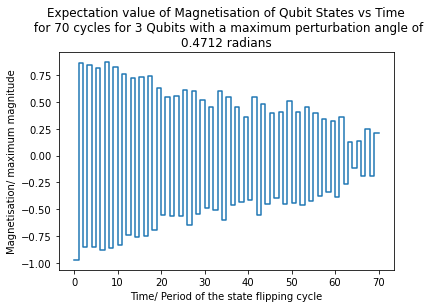

In [4]:
from qiskit import QuantumCircuit, execute, Aer#, IBMQ
from qiskit.visualization import plot_histogram
import scipy
from scipy import pi as pi
import matplotlib.pyplot as plt
import numpy as np 
from qiskit.chemistry import fermionic_operator as F

"""
# This is the code I attempted to use to run QTC2 on a real device.
IBMQ.load_account()
backend2 = Aer.get_backend('qasm_simulator')
provider = IBMQ.get_provider('ibm-q')
backend3 = provider.get_backend('ibmq_athens')
"""

def QTC2(L, q, ang):
    """
    I've defined the number of cycles the code is run over as L, and q is the number of qubits being simulated.
    ang is an argument I added later as a rough magnitude of the rotation angle, which is then randomised
    
    This function takes all the qubits initially in [1, 0] or |0> state, and flips the spins, performs a rotation
    operation on each qubit relative to another one, another rotation is then performed which randomised the spin
    orientation and "measures" the resulting state. I say "measure" since it's
    run on a simulator and no actual measurement is being carried out on a quantum device.
    
    Once it's been run over all cycles, the resulting data is stored in a list which is appended after each cycle recording 
    the state measured and the probability of measuring that state. We then include a barrier between each cycle, so it's
    clear each cycle is performed independently.
    
    From this data, the graph plotting magnetisation vs time expressed as the number of cycles the system has gone though, 
    is plotted and it should show the system has a period double that of the driving field.
    """
    qtc = QuantumCircuit(q)
    backend = Aer.get_backend('statevector_simulator')
    for i in range(q):
        qtc.initialize([1,0], i)
    statedata = []
    histogram = []
    mag = []; T = []
    for i in range(L):    
        for j in range(q):
            qtc.x(j)
            #qtc.h(j)
        # These are the rotational control gates coupling qubits. The code I attempted to implement this automatically
        # didn't run too well, this was the second attempt running the code. 
        for k in range(q):
            # theta = pi/4 * np.random.randint(1, 15)/20 # Attempted to introduce this random number for the angle but
            # it had no discernable affect on the histogram plot but may have an affect on the statedata.
            if k + 1 < q:
                qtc.crz(pi/2, k, k+1)
            else: break
        
        # This is the code added to randomise the rotation angle around x. 
        for k in range(q):
            theta = (ang) * (np.random.randint(1, 15)/20) # Attempted to introduce this random number for the angle
            # to simulate randomness of quantum behaviour to the environment
            qtc.rx(theta, k)
            
    # This loop happens at the end to change back to the z basis the computer prefers to operate in, or any other gate
    # when operating in a different basis
        #for j in range(q):
            #qtc.h(j)

        # This is the code to run with q = 3, 3 qubits coupled to the consecutive one.
        #qtc.cp(pi/2, 0, 1)
        #qtc.cp(pi/2, 1, 2)
        
        
        # This code calculated the exact state, which was helpful to ensure the code was running 
        # as I hoped and will now be employed to make a more accurate plot.
        
        # N.B. When running on a real device, this form can't be used as "statevector" doesn't appear to exist in the 
        # returned results. So, probably worth running the code in a stripped back form and seeing what the results 
        # actually are in this format...
        state = execute(qtc, backend).result().get_statevector()
        #print("Quibits state is = ", state)
        
        statedata.append(state)
        results = execute(qtc, backend).result().get_counts()
        #print(results)
        histogram.append(results)
        #counts = state.get_counts()
        #print(state)
        
        # Trying to determine the magnetization from the states... This is needed to get the expectation value of
        # the magnetisation from the total magnetisation operator acting on the state times the complex conjugate of the
        # state itself, which can be determined by numpy.
        #magval = F.total_magnetization(state)
        #print(magval)
        M = Magexpval(q, results, state)
        mag.append(M)
        mag.append(M)
        #print(M)
        T.append(i)
        T.append(i+1)
        qtc.barrier()
    #qtc.draw()
    #print(histogram, '\n',statedata, '\n')
    #plot_histogram(histogram)
    
    # This commented out for loop below assumed the system to be in all 0s or all 1s, I've since modified the code 
    # so this is now obsolete, but can be run for sufficiently small angles when the rotation is negligible
    """
    for i in range(len(histogram)):
        if str(q*'0') in histogram[i]:
            mag.append(1)
            mag.append(1)
        elif str(q*'1') in histogram[i]:
            mag.append(-1)
            mag.append(-1)
        else: break
        T.append(i)
        T.append(i+1)
    """   
    # The above code is "okay", however it would be better to obtain the expectation value of the magnetisation
    # in each state, and since we have the statevectors, we can do just that with the magnetisation operator relative
    # to a quantisation axis (usually taken to be z-axis). This is what I'm attempting to calculate in the main for loop
    # and this will replace values in the mag array being plotted below, with use of the Magexpval function. 
        
        
    
    # Now it's just taking everything previously and plotting it on a graph.
    # There's also the option to uncomment filename and plt.savefig to save to the sub folder with the MPHYS project work
    # in it reserved for plots from this code; it may be worth generating a few more plots to illustrate the general idea
    # and make the presentation look busier.
    fig = plt.figure()
    ax = plt.axes()

    ax.plot(T, mag)
    title = str("Expectation value of Magnetisation of Qubit States vs Time\n for " + str(L) + " cycles for " + str(q) + 
                " Qubits with a maximum perturbation angle of\n" + f"{(ang)*3/4:.4f}" + " radians")
    #filename = str("Graph of Expectation value of Magnetisation vs Time for "+ str(L) + " cycles for " + str(q) + 
    #            " Qubits with a maximum perturbation angle of " + f"{(ang)*3/4:.4f}" + " radians")
    plt.title(title)
    plt.xlabel("Time/ Period of the state flipping cycle")
    plt.ylabel("Magnetisation/ maximum magnitude")
    #plt.savefig('Documents\MPHYS project\Realisation of QTC code plots/'+filename+'.png')
    
    return

QTC2(70, 3, pi/5)

I think I have something I'm relatively proud of. Magnetisation works quite well, and for larger thermal fluctuations being simulated the coherence of the time crystal starts to break down. However, having more qubits increases the stability somewhat, however this is just the expectation value and results could differ in reality.

Error notice: Doesn't seem to like it for more than 5 qubits... It produces an error saying list index labels[i][l] is out of range, yet it shouldn't be as it works for 5 or less qubits. Maybe try fixing with a condition that stops it at a certain point idk, run a different code for q > 5 which stops it at a certain point before the code crashes: a q < 6 and a q > 5 condition?

I tried running it with hadamard rather than x gates, and the code took a while but didn't crash... It looked weirdly periodic, but I can honestly say I'm not sure what to make of it.

It also seems to crash at small angles, I think because it has to handle values which are too small and aren't recorded in the labels being indexed. So, perhaps a while loop would be more appropriate here; I may make this change at a later date.

I tried to run it on a real device and got a messy error message, but I did try it out. I think I needed to change the result I wanted to use from this step later in the results. I think trying to realise quantum time crystals on real qubit devices could be a good way to go with the project.

In [ ]:
# The error message when the above code was run with backend3:
---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
~\Anaconda3\envs\Coding-in-Qiskit\lib\site-packages\qiskit\result\result.py in get_statevector(self, experiment, decimals)
    300         try:
--> 301             return postprocess.format_statevector(self.data(experiment)['statevector'],
    302                                                   decimals=decimals)

KeyError: 'statevector'

During handling of the above exception, another exception occurred:

QiskitError                               Traceback (most recent call last)
<ipython-input-57-d01d846ad066> in <module>
    138     return
    139 
--> 140 QTC2(5, 3, 2*pi/11)

<ipython-input-57-d01d846ad066> in QTC2(L, q, ang)
     67         # This code calculated the exact state, which was helpful to ensure the code was running
     68         # as I hoped and will now be employed to make a more accurate plot.
---> 69         state = execute(qtc, backend3).result().get_statevector()
     70         #print("Quibits state is = ", state)
     71 

~\Anaconda3\envs\Coding-in-Qiskit\lib\site-packages\qiskit\result\result.py in get_statevector(self, experiment, decimals)
    302                                                   decimals=decimals)
    303         except KeyError:
--> 304             raise QiskitError('No statevector for experiment "{}"'.format(experiment))
    305 
    306     def get_unitary(self, experiment=None, decimals=None):

QiskitError: 'No statevector for experiment "None"'

In [20]:
print(type(f"{(pi/5)*3/4:.5f}")) # Just test code to see format the maximum angle into a more readable form.

<class 'str'>


In [55]:
# A cell with the details about running the code on a real device...
Token = '059b413a0770a5ac5b1c2fa64588e5958068c9bbc72c955f75bc9842050ca190ee995292c3430a1a28305407af2c83f7b79f8bf0974f24f8017dac1ba8be3b7d'
IBMQ.save_account(Token)
IBMQ.load_account()
backend2 = Aer.get_backend('qasm_simulator')
#backend3 = Aer.get_backend('athens')

configrc.store_credentials:WARNING:2021-02-11 17:35:20,096: Credentials already present. Set overwrite=True to overwrite.
C:\Users\Jenni\Anaconda3\envs\Coding-in-Qiskit\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


QiskitBackendNotFoundError: 'No backend matches the criteria'

In [56]:
IBMQ.load_account()
backend2 = Aer.get_backend('qasm_simulator')
provider = IBMQ.get_provider('ibm-q')
backend3 = provider.get_backend('ibmq_athens')

ibmqfactory.load_account:WARNING:2021-02-11 17:38:04,423: Credentials are already in use. The existing account in the session will be replaced.
